In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from utils import TrainTest, PlotOutput
from dataset import ACIFAR10

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = TrainTest.get_device()
device

'cuda'

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [0.49139968, 0.48215841, 0.44653091] # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [0.24703223, 0.24348513, 0.26158784] # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_height=16, min_width=16, fill_value=0, p=0.6),
        A.Resize(32, 32),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ]
)

In [4]:
# datasets
trainset = ACIFAR10(
    mean=mean, std=std, root='./data', train=True, download=True, transform=train_transform)

testset = ACIFAR10(
    mean=mean, std=std, root='./data', train=False, download=True, transform=test_transform)

# dataloaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


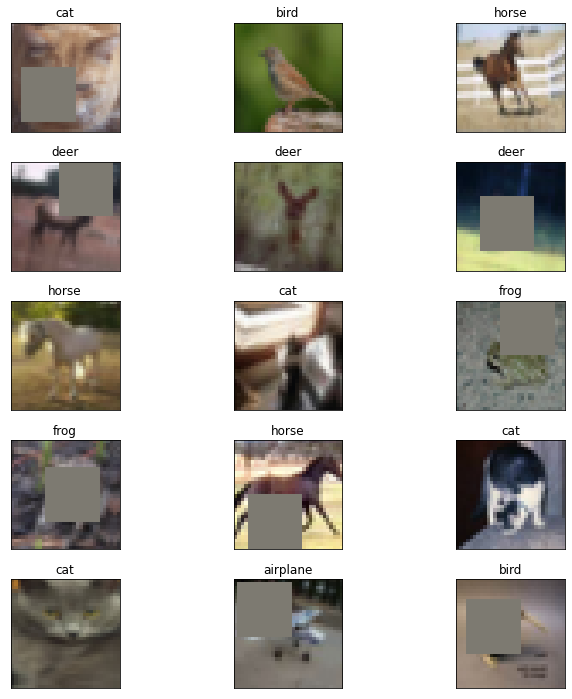

In [5]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label = next(iter(train_loader))

t_std = torch.tensor(std).reshape(3, 1, 1)
t_mean = torch.tensor(mean).reshape(3, 1, 1)


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [6]:
"""
RF_out = RF_in + (kernel-1) * J_in
J_out = J_in * stride
"""

'\nRF_out = RF_in + (kernel-1) * J_in\nJ_out = J_in * stride\n'

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, dropout=0.1):
        super(BasicBlock, self).__init__()
        cblock1 = nn.Sequential(
            nn.Conv2d(
                in_planes,
                in_planes,
                kernel_size=3,
                padding=1,
                bias=False,
                groups=in_planes,
            ),
            nn.BatchNorm2d(in_planes),
            nn.ReLU(),
            nn.Conv2d(in_planes, planes, kernel_size=1),
            nn.BatchNorm2d(planes),
        )

        cblock2 = nn.Sequential(
            nn.Conv2d(
                planes, planes, kernel_size=3, padding=1, groups=planes, bias=False
            ),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
            nn.Conv2d(planes, planes, kernel_size=1),
            nn.BatchNorm2d(planes),
        )

        self.blocks = nn.Sequential(*[cblock1, cblock2])
        self.skip = nn.Sequential()

        if in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x, skip=True):
        out = self.blocks(x)

        if skip:
            out += self.skip(x)

        out = F.relu(out)
        return out


class Net(nn.Module):
    def __init__(
        self,
        block,
        num_blocks,
        num_channels,
        nclass=10,
        dropout=0.1,
        logit_layer="pooling",
    ):
        super(Net, self).__init__()
        start_planes = num_channels[0]

        self.in_planes = start_planes

        self.cblock1 = nn.Sequential(
            nn.Conv2d(3, start_planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(start_planes),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.layer1 = self._make_layer(
            block, num_channels[0], num_channels[1], num_blocks[0], dropout=dropout
        )
        self.tlayer1 = self._transition(
            inplanes=num_channels[1],
            planes=num_channels[1] // 4,
            dilation=2,
            dropout=dropout,
        )

        self.layer2 = self._make_layer(
            block, num_channels[1] // 4, num_channels[2], num_blocks[1], dropout=dropout
        )
        self.tlayer2 = self._transition(
            inplanes=num_channels[2],
            planes=num_channels[2] // 4,
            dilation=4,
            dropout=dropout,
        )

        self.layer3 = self._make_layer(
            block, num_channels[2] // 4, num_channels[3], num_blocks[2], dropout=dropout
        )
        self.tlayer3 = self._transition(
            inplanes=num_channels[3],
            planes=num_channels[3] // 4,
            dilation=8,
            dropout=dropout,
        )

        if logit_layer == "linear":
            self.logit_layer = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(num_channels[3] // 4, nclass),
            )

        else:
            self.logit_layer = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(num_channels[3] // 4, nclass, kernel_size=1),
                nn.Flatten(),
            )

    def _make_layer(self, block, in_planes, planes, num_blocks, dropout):
        layers = []

        for _ in range(num_blocks):
            layers.append(block(in_planes, planes, dropout))

        return nn.Sequential(*layers)

    def _transition(self, inplanes, planes, dilation, dropout):
        return nn.Sequential(
            nn.Conv2d(
                inplanes,
                planes,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False,
                dilation=dilation,
            )
        )

    def forward(self, x):
        out = self.cblock1(x)

        out = self.tlayer1(self.layer1(out))
        out = self.tlayer2(self.layer2(out))
        out = self.tlayer3(self.layer3(out))

        out = self.logit_layer(out)
        return out


class Cifar200k(Net):
    def __init__(self, nclass=10, dropout=0.01, logit_layer="pooling"):
        super(Cifar200k, self).__init__(block=BasicBlock, 
                                       num_channels=[64, 128, 128, 128], 
                                       num_blocks=[1, 1, 1, 1], 
                                       nclass=nclass, 
                                       dropout=dropout, 
                                       logit_layer=logit_layer)

model = Cifar200k(logit_layer="pooling").to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]             576
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]           8,320
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]           1,152
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          16,512
      BatchNorm2d-14          [-1, 128,

In [8]:
criterion = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, factor=0.1)

In [9]:
target_layers = [model.tlayer3, model.layer3, model.tlayer2, model.layer2]
EPOCHS = 25

run = TrainTest(model=model, 
                trainloader=train_loader, 
                testloader=test_loader, 
                optimizer=optimizer, 
                criterion=criterion, 
                scheduler=scheduler,
                target_layers=target_layers)

image_idx = [15, 25, 446, 416, 96]
run(epochs=EPOCHS, cam=True, image_idx=image_idx)
# run.save_grad_cam_gif(image_idx=image_idx, output_directory="./cam_output/")

Train: Loss=1.4476 Batch_id=1562 Accuracy=47.30: 100%|██████████| 1563/1563 [00:26<00:00, 59.55it/s]


Test set: Average loss: 1.3418, Accuracy: 5596/10000 (55.96%)



Train: Loss=1.1018 Batch_id=1562 Accuracy=60.83: 100%|██████████| 1563/1563 [00:26<00:00, 59.49it/s]


Test set: Average loss: 0.8727, Accuracy: 7050/10000 (70.50%)



Train: Loss=0.9648 Batch_id=1562 Accuracy=66.05: 100%|██████████| 1563/1563 [00:26<00:00, 59.30it/s]


Test set: Average loss: 0.8194, Accuracy: 7106/10000 (71.06%)



Train: Loss=0.8826 Batch_id=1562 Accuracy=69.06: 100%|██████████| 1563/1563 [00:26<00:00, 59.34it/s]


Test set: Average loss: 0.6837, Accuracy: 7627/10000 (76.27%)



Train: Loss=0.8301 Batch_id=1562 Accuracy=71.04: 100%|██████████| 1563/1563 [00:26<00:00, 59.02it/s]


Test set: Average loss: 0.6568, Accuracy: 7727/10000 (77.27%)



Train: Loss=0.7865 Batch_id=1562 Accuracy=72.39: 100%|██████████| 1563/1563 [00:25<00:00, 61.12it/s]


Test set: Average loss: 0.6761, Accuracy: 7768/10000 (77.68%)



Train: Loss=0.7489 Batch_id=1562 Accuracy=73.89: 100%|██████████| 1563/1563 [00:26<00:00, 58.25it/s]


Test set: Average loss: 0.5863, Accuracy: 8005/10000 (80.05%)



Train: Loss=0.7165 Batch_id=1562 Accuracy=74.88: 100%|██████████| 1563/1563 [00:25<00:00, 61.25it/s]


Test set: Average loss: 0.5698, Accuracy: 8063/10000 (80.63%)



Train: Loss=0.6946 Batch_id=1562 Accuracy=75.63: 100%|██████████| 1563/1563 [00:27<00:00, 57.79it/s]


Test set: Average loss: 0.6002, Accuracy: 7987/10000 (79.87%)



Train: Loss=0.6745 Batch_id=1562 Accuracy=76.43: 100%|██████████| 1563/1563 [00:26<00:00, 60.08it/s]


Test set: Average loss: 0.5732, Accuracy: 8066/10000 (80.66%)

Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.


Train: Loss=0.5856 Batch_id=1562 Accuracy=79.55: 100%|██████████| 1563/1563 [00:26<00:00, 57.91it/s]


Test set: Average loss: 0.4686, Accuracy: 8410/10000 (84.10%)



Train: Loss=0.5536 Batch_id=1562 Accuracy=80.77: 100%|██████████| 1563/1563 [00:26<00:00, 58.67it/s]


Test set: Average loss: 0.4624, Accuracy: 8435/10000 (84.35%)



Train: Loss=0.5423 Batch_id=1562 Accuracy=80.92: 100%|██████████| 1563/1563 [00:26<00:00, 58.48it/s]


Test set: Average loss: 0.4596, Accuracy: 8439/10000 (84.39%)



Train: Loss=0.5384 Batch_id=1562 Accuracy=81.10: 100%|██████████| 1563/1563 [00:26<00:00, 59.16it/s]


Test set: Average loss: 0.4517, Accuracy: 8462/10000 (84.62%)



Train: Loss=0.5367 Batch_id=1562 Accuracy=81.35: 100%|██████████| 1563/1563 [00:26<00:00, 59.74it/s]


Test set: Average loss: 0.4465, Accuracy: 8467/10000 (84.67%)



Train: Loss=0.5238 Batch_id=1562 Accuracy=81.61: 100%|██████████| 1563/1563 [00:26<00:00, 59.28it/s]


Test set: Average loss: 0.4468, Accuracy: 8500/10000 (85.00%)



Train: Loss=0.5231 Batch_id=1562 Accuracy=81.72: 100%|██████████| 1563/1563 [00:26<00:00, 58.61it/s]


Test set: Average loss: 0.4433, Accuracy: 8507/10000 (85.07%)



Train: Loss=0.5153 Batch_id=1562 Accuracy=82.04: 100%|██████████| 1563/1563 [00:26<00:00, 58.41it/s]


Test set: Average loss: 0.4334, Accuracy: 8535/10000 (85.35%)



Train: Loss=0.5126 Batch_id=1562 Accuracy=82.25: 100%|██████████| 1563/1563 [00:26<00:00, 59.66it/s]


Test set: Average loss: 0.4346, Accuracy: 8542/10000 (85.42%)



Train: Loss=0.5066 Batch_id=1562 Accuracy=82.07: 100%|██████████| 1563/1563 [00:26<00:00, 59.45it/s]


Test set: Average loss: 0.4377, Accuracy: 8517/10000 (85.17%)

Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.


Train: Loss=0.4970 Batch_id=1562 Accuracy=82.68: 100%|██████████| 1563/1563 [00:26<00:00, 59.17it/s]


Test set: Average loss: 0.4300, Accuracy: 8556/10000 (85.56%)



Train: Loss=0.4935 Batch_id=1562 Accuracy=82.79: 100%|██████████| 1563/1563 [00:26<00:00, 59.03it/s]


Test set: Average loss: 0.4301, Accuracy: 8543/10000 (85.43%)



Train: Loss=0.4934 Batch_id=1562 Accuracy=82.80: 100%|██████████| 1563/1563 [00:25<00:00, 61.96it/s]


Test set: Average loss: 0.4308, Accuracy: 8554/10000 (85.54%)

Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


Train: Loss=0.4908 Batch_id=1562 Accuracy=82.82: 100%|██████████| 1563/1563 [00:26<00:00, 58.21it/s]


Test set: Average loss: 0.4298, Accuracy: 8548/10000 (85.48%)



Train: Loss=0.4925 Batch_id=1562 Accuracy=82.64: 100%|██████████| 1563/1563 [00:26<00:00, 58.74it/s]


Test set: Average loss: 0.4277, Accuracy: 8564/10000 (85.64%)



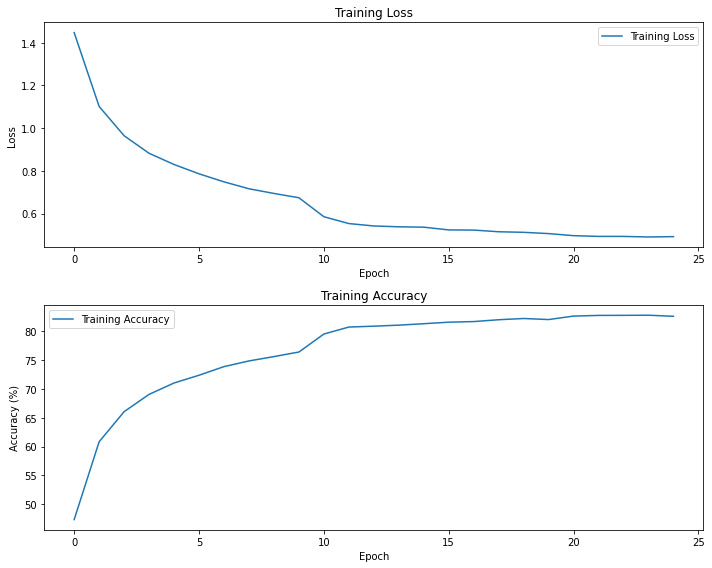

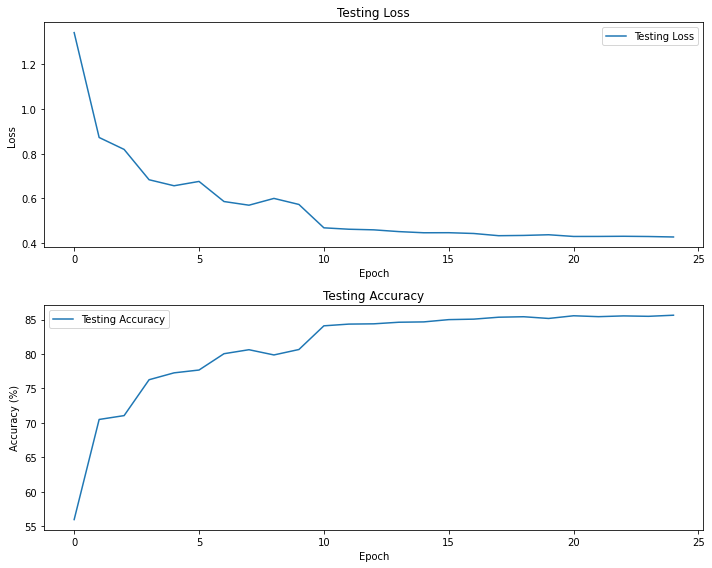

In [10]:
run.train.plot_stats()
run.test.plot_stats()

In [24]:
plot = PlotOutput(model, target_layers=target_layers, device=device)

100%|██████████| 313/313 [00:18<00:00, 17.35it/s]


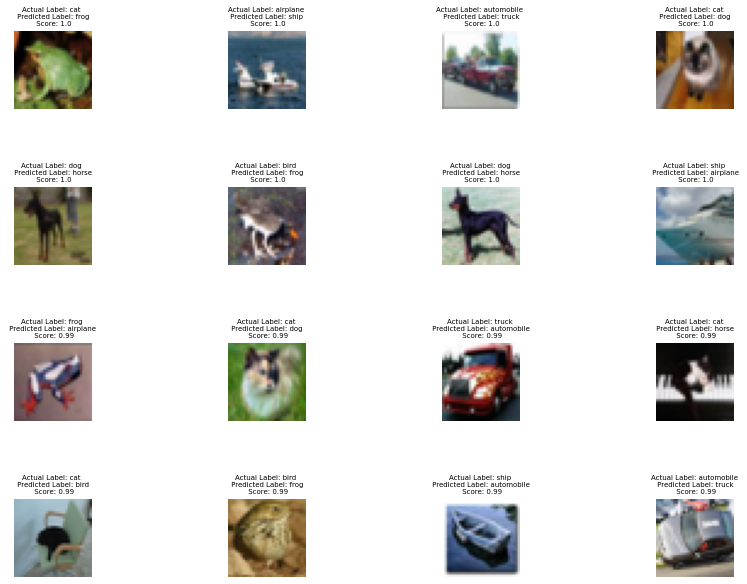

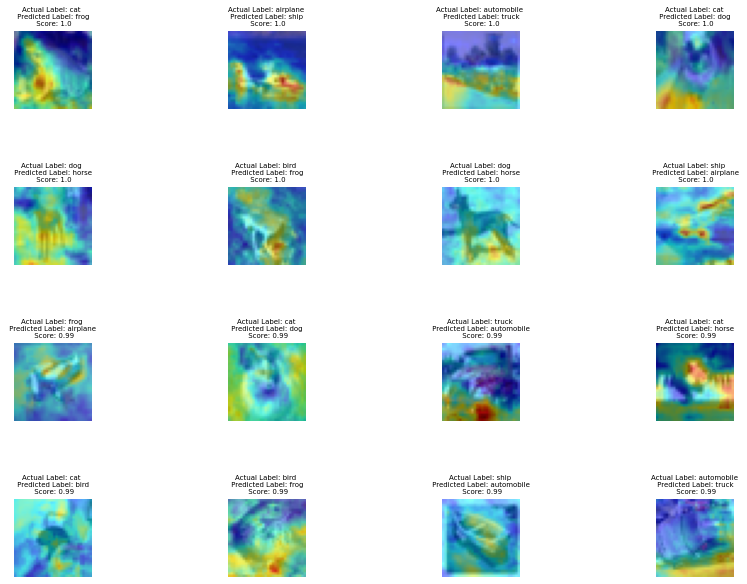

In [25]:
plot.run_prediction(test_loader, ptype="incorrect")

plot.plot(n=16, class_list=classes, grad_cam=False)
plot.plot(n=16, class_list=classes, grad_cam=True)

100%|██████████| 313/313 [00:12<00:00, 24.89it/s]


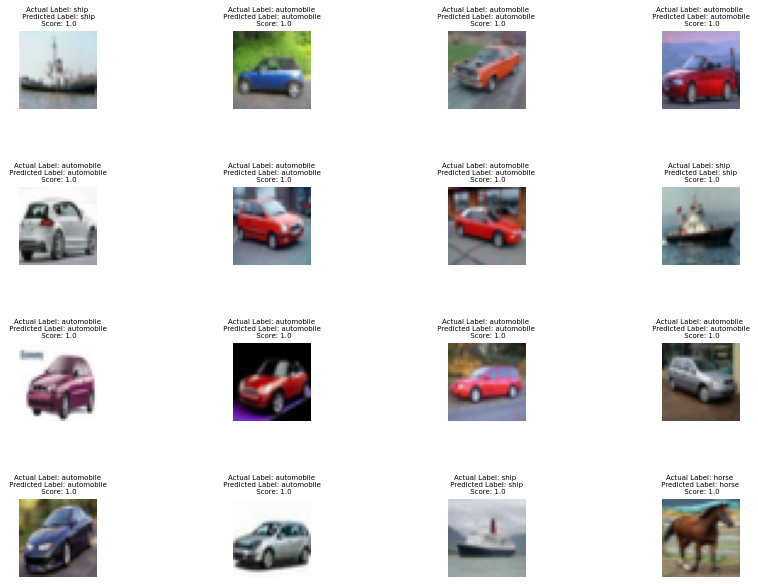

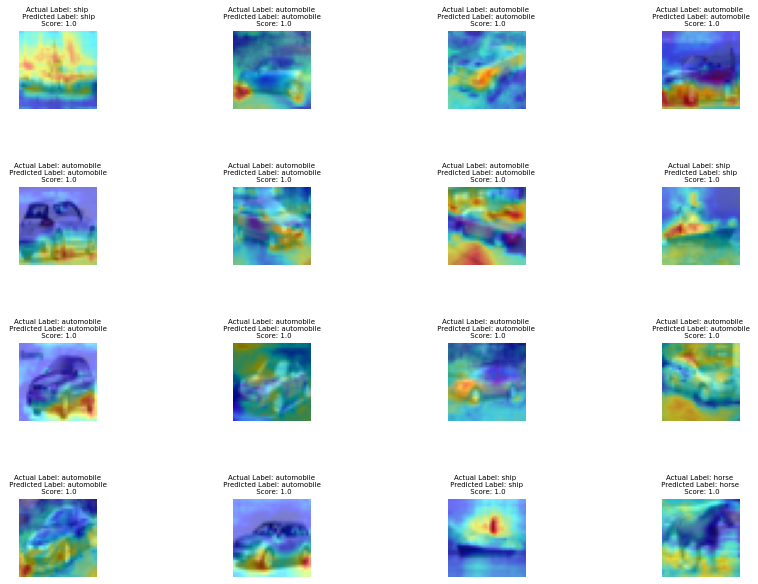

In [26]:
plot.run_prediction(test_loader, ptype="correct")

plot.plot(n=16, class_list=classes, grad_cam=False, reverse=True)
plot.plot(n=16, class_list=classes, grad_cam=True, reverse=True)